In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from PredyNet_modules import *
import gym

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
env = gym.make("LunarLander-v2")
env.reset()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


array([-0.00522051,  0.94182225, -0.52879448,  0.0805726 ,  0.00605603,
        0.11977977,  0.        ,  0.        ])

In [3]:
action_space = env.action_space.n
obs_space = env.observation_space.shape[0]

In [4]:
ySize = 8
predynet = PredyNet(inSize=obs_space, dSize=ySize)
yPrev = torch.randn(ySize)
ePrev = torch.zeros(obs_space)
optimizer = torch.optim.SGD(predynet.parameters(), lr=0.1)
# optimizer = torch.optim.Adam(predynet.parameters(), lr=0.01)
criterion = F.smooth_l1_loss
# criterion = nn.SmoothL1Loss()

In [5]:
act = env.action_space.sample()
observation = torch.Tensor(env.step(act)[0])

In [61]:
timelength = 10000
Loss = np.zeros((timelength))
rX = np.zeros_like(Loss)
pX = np.zeros_like(rX)

env.reset()
act = env.action_space.sample()

for t in range(timelength):
    if np.random.rand() < 0.1:
        act = env.action_space.sample()
        
    obs_out = env.step(act)
    observation = torch.Tensor(obs_out[0])
    done = obs_out[2]
    
    optimizer.zero_grad()

    err, ePrev, y, yPrev, Rec = predynet(observation[0], yPrev.detach(), ePrev)
    loss = criterion(Rec, observation)
    loss.backward()
    optimizer.step()
    
    rX[t] = obs_out[0][0]
    pX[t] = Rec.data.numpy()[0]    
    Loss[t] = loss.data.numpy()
    
    if done:
        env.reset()

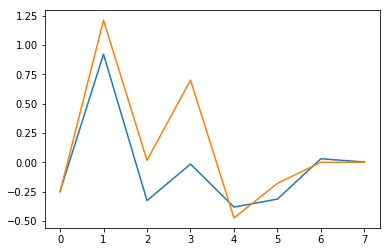

In [62]:
plt.plot(Rec.data.numpy())
plt.plot(obs_out[0])

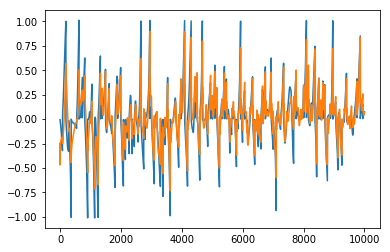

In [49]:
plt.plot(rX)
plt.plot(pX)
# plt.plot(rX-pX, 'r:')

In [63]:
timelength = 1000
Loss = np.zeros((timelength))
rX = np.zeros_like(Loss)
pX = np.zeros_like(rX)
Y = np.zeros((ySize, timelength))
env.reset()
act = env.action_space.sample()

for t in range(timelength):
    if np.random.rand() < 0.1:
        act = env.action_space.sample()
        
    obs_out = env.step(act)
    observation = torch.Tensor(obs_out[0])
    done = obs_out[2]
    
    err, ePrev, y, yPrev, Rec = predynet(observation[0], yPrev.detach(), ePrev)
    loss = criterion(Rec, observation)
    
    rX[t] = obs_out[0][0]
    pX[t] = Rec.data.numpy()[0]    
    Loss[t] = loss.data.numpy()
    Y[:,t] = y.data.numpy()
    
    if done:
        env.reset()

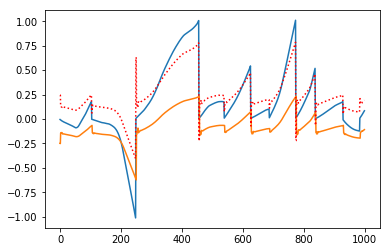

In [64]:
plt.plot(rX)
plt.plot(pX)
plt.plot(rX-pX, 'r:')

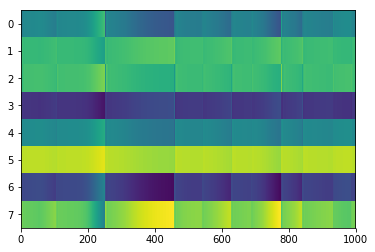

In [65]:
plt.imshow(Y, aspect="auto", interpolation="nearest")

In [66]:
yPrev.size()

torch.Size([8])

In [67]:
tmp = nn.LSTM(obs_space+action_space, 10)
act_tens = torch.eye(action_space)[act]
yPrev = torch.randn(1, 10).unsqueeze(0)
yPrev2 = torch.randn(1, 10).unsqueeze(0)
YP = (yPrev, yPrev2)
Inp = torch.cat((observation, act_tens), 0).unsqueeze(0).unsqueeze(0)

In [5]:
# from PredyNet_modules import *

rec_model = PredyNet_LSTM(obs_space, action_space, 20)
yPrev = rec_model.init_hidden()

In [212]:
optimizer = torch.optim.Adam(rec_model.parameters(), lr=0.1)
criterion = nn.MSELoss()
criterion = F.smooth_l1_loss

In [213]:
act = env.action_space.sample()
observation = torch.Tensor(env.step(act)[0])

In [214]:
timelength = 10000
Loss = np.zeros((timelength))
rX = np.zeros_like(Loss)
pX = np.zeros_like(rX)
Rew = np.zeros_like(rX)

env.reset()
act = env.action_space.sample()
act_tens = torch.eye(action_space)[act]

for t in range(timelength):
    if np.random.rand() < 0.1:
        act = env.action_space.sample()
        act_tens = torch.eye(action_space)[act]

    obs_out = env.step(act)
    observation = torch.Tensor(obs_out[0])
    done = obs_out[2]
    
    optimizer.zero_grad()
    
    model_input = torch.cat((observation, act_tens), 0)
    loss = 0
    for ind in range(2):
        Rec = rec_model(model_input)

        rec = Rec.squeeze()
        loss_ = criterion(rec, observation)
        loss += loss_
    rloss = obs_out[1] / 100
    loss -= rloss
    loss.backward()
    optimizer.step()
    
    rX[t] = obs_out[0][0]
    pX[t] = rec.data.numpy()[0]    
    Loss[t] = loss.data.numpy()
    Rew[t] = obs_out[1]
    
    if done:
        env.reset()

RuntimeError: input.size(-1) must be equal to input_size. Expected 13, got 12

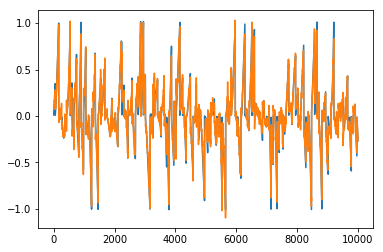

In [34]:
plt.plot(rX)
plt.plot(pX)
# plt.plot(rX-pX, 'r:')

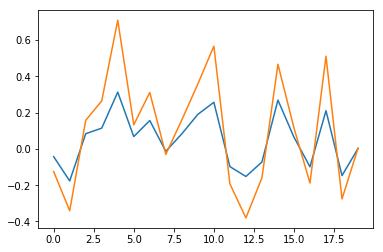

In [35]:
plt.plot(rec_model.hidden[0].squeeze().data.numpy())
plt.plot(rec_model.hidden[1].squeeze().data.numpy())

In [156]:
timelength = 1000
Loss = np.zeros((timelength))
rX = np.zeros_like(Loss)
pX = np.zeros_like(rX)

env.reset()
act = env.action_space.sample()
act_tens = torch.eye(action_space)[act]

for t in range(timelength):
    if np.random.rand() < 0.1:
        act = env.action_space.sample()
        act_tens = torch.eye(action_space)[act]

    obs_out = env.step(act)
    observation = torch.Tensor(obs_out[0])
    done = obs_out[2]
        
    model_input = torch.cat((observation, act_tens), 0)

    Rec = rec_model(model_input)
    rec = Rec.squeeze()
    loss = criterion(rec, observation)
    
    rX[t] = obs_out[0][0]
    pX[t] = rec.data.numpy()[0]    
    Loss[t] = loss.data.numpy()
    
    if done:
        env.reset()

RuntimeError: input.size(-1) must be equal to input_size. Expected 13, got 12

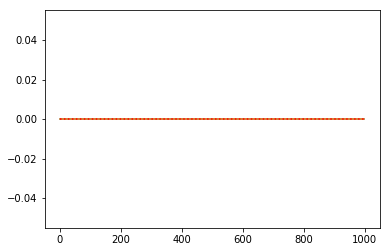

In [157]:
plt.plot(rX)
plt.plot(pX)
plt.plot(rX-pX, 'r:')

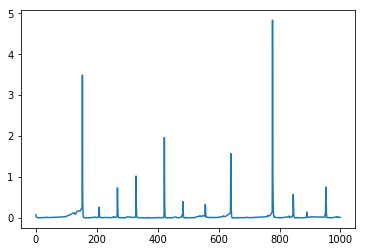

In [38]:
plt.plot(Loss)

In [ ]:
# from PredyNet_modules import *

rec_model = action_LSTM(obs_space, action_space, 30)
yPrev = rec_model.init_hidden()

In [8]:
optimizer = torch.optim.Adam(rec_model.parameters(), lr=0.1)
criterion = nn.MSELoss()
criterion_act = nn.BCELoss()

In [9]:
act = env.action_space.sample()
observation = torch.Tensor(env.step(act)[0])

In [10]:
timelength = 20000
Loss = np.zeros((timelength))
rX = np.zeros_like(Loss)
pX = np.zeros_like(rX)
Rew = np.zeros_like(rX)
act_vec = np.zeros((env.action_space.n, timelength))
ract_vec = np.zeros_like(act_vec)

env.reset()
act = env.action_space.sample()
act_tens = torch.eye(action_space)[act]
rloss = 0
for t in range(timelength):
    if np.random.rand() < 0.1:
        act = env.action_space.sample()
        act_tens = torch.eye(action_space)[act]

    obs_out = env.step(act)
    rew_out = torch.Tensor([obs_out[1]/100])
    obsies = torch.Tensor(obs_out[0])
    observation = torch.cat((rew_out, obsies), 0)
    done = obs_out[2]
    
    optimizer.zero_grad()
    
    model_input = torch.cat((observation, act_tens), 0)
    Rec, act_pred = rec_model(model_input)

    rec = Rec.squeeze()
    act_pred = act_pred.squeeze()
    
    loss = criterion(rec, observation)
    act_loss = criterion_act(act_pred, act_tens)
    
    rloss = obs_out[1] / 100
    loss.backward()
    act_loss.backward()
    optimizer.step()
    
    rX[t] = obs_out[0][0]
    pX[t] = rec.data.numpy()[0]    
    Loss[t] = loss.data.numpy()
    Rew[t] = obs_out[1]
    act_vec[:,t] = act_pred.data.numpy()
    ract_vec[:,t] = act_tens.data.numpy()
    
    if done:
        env.reset()

In [11]:
timelength = 4000
Loss = np.zeros((timelength))
rX = np.zeros((obs_space+1, timelength))
pX = np.zeros_like(rX)
Rew = np.zeros_like(Loss)
act_vec = np.zeros((env.action_space.n, timelength))
ract_vec = np.zeros_like(act_vec)

env.reset()
act = env.action_space.sample()
act_tens = torch.eye(action_space)[act]

for t in range(timelength):
    act = torch.argmax(act_pred)
    act_tens = torch.eye(action_space)[act]

    obs_out = env.step(act.data.numpy())
    rew_out = torch.Tensor([obs_out[1]/100])
    obsies = torch.Tensor(obs_out[0])
    observation = torch.cat((rew_out, obsies), 0)
    done = obs_out[2]
    
    optimizer.zero_grad()
    
    model_input = torch.cat((observation, act_tens), 0)
    Rec, act_pred = rec_model(model_input)
    

    rec = Rec.squeeze()
    act_pred = act_pred.squeeze()
    
    rloss = obs_out[1] / 100

    loss = criterion(rec, observation)
    act_loss = criterion_act(act_pred, act_tens)
    
    
    rX[:,t] = observation.data.numpy()
    pX[:,t] = rec.data.numpy()   
    Loss[t] = loss.data.numpy()
    Rew[t] = obs_out[1]
    act_vec[:,t] = act_pred.data.numpy()
    ract_vec[:,t] = act_tens.data.numpy()
    
    if done:
        env.reset()

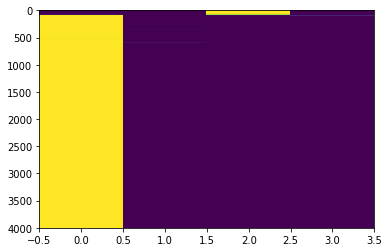

In [12]:
plt.imshow(act_vec.T, aspect="auto")

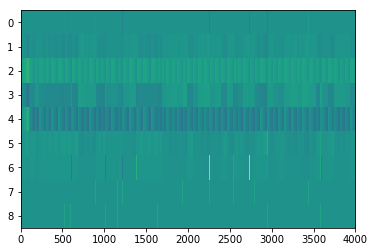

In [13]:
plt.imshow(rX, aspect="auto")

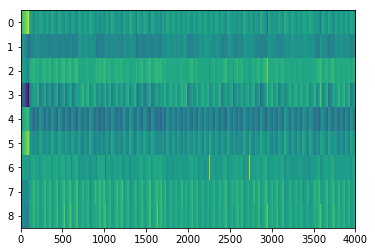

In [14]:
plt.imshow(pX, aspect="auto")

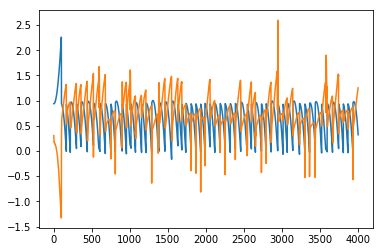

In [15]:
ind = 2
plt.plot(rX[ind,:])
plt.plot(pX[ind,:])

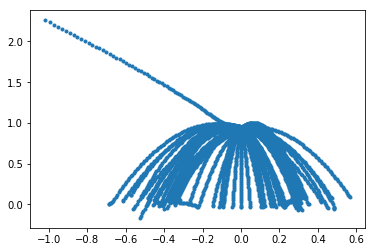

In [16]:
plt.plot(rX[1,:], rX[2,:],'.')

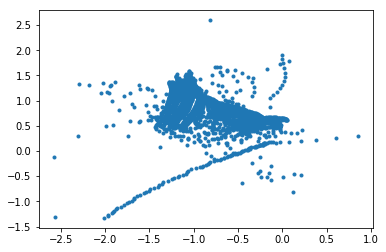

In [17]:
plt.plot(pX[1,:], pX[2,:],'.')

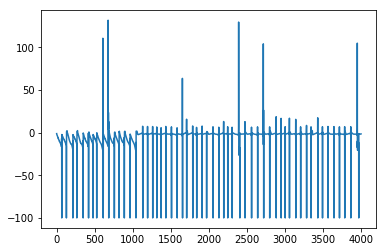

In [18]:
plt.plot(Rew)

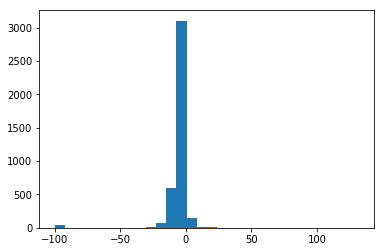

In [239]:
plt.hist(Rew, bins=30);

In [211]:
np.mean(Rew)

-4.014400237972195

In [45]:
torch.cat((torch.ones(1), obs_out[1]), 0)

TypeError: expected Variable as element 1 in argument 0, but got tuple

torch.Size([8])